In [1]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import playbyplay,leaguegamefinder,leaguedashteamstats
from nba_api.stats.static import teams
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep
from tqdm.notebook import tqdm
pd.options.display.max_columns = None
from scipy import stats
from fitter import Fitter
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import flexcode
from flexcode.regression_models import XGBoost
from xgboost import XGBRegressor
import optuna


In [2]:
NBA_TEAMS = ['DEN', 'LAC', 'CHA', 'ORL', 'IND', 'NOP', 'UTA', 'TOR', 'MIA','SAC', 'POR', 'BKN', 'GSW', 'LAL', 'PHI', 'MIL', 'CHI', 'HOU','MEM', 'DET', 'DAL', 'CLE', 'MIN', 'OKC', 'PHX', 'NYK',
     'SAS', 'WAS', 'ATL','BOS']

In [9]:
all_runs_to = pd.concat([#pd.read_pickle('C:/Users/isaac/Desktop/Proyectos/nba_analysis/timeout_analysis/preprocessing/data/all_runs_to_2015-2018.pkl'),
                         pd.read_pickle('C:/Users/isaac/Desktop/Proyectos/nba_analysis/timeout_analysis/preprocessing/data/all_runs_to_2019-2023.pkl')])

In [10]:
all_runs_to.head()

,run_id_gp,gp,home_team,away_team,home_score,away_score,run_length,to,home_to,away_to,to_index,changed_run,run_team,next_run_length,next_run_home_score,next_run_away_score,next_run_team,previous_run_length,previous_run_home_score,previous_run_away_score,previous_run_team,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,to_team,to_non_run,previous_run_time,last_run_time,time_spent_run,to_time
0,2,00119000011,HOU,SDS,3.0,0.0,4,0,0,0,0,0,HOU,1,3.0,2.0,SDS,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720,25,695,NaN
1,3,00119000011,HOU,SDS,3.0,2.0,1,0,0,0,0,0,SDS,2,8.0,2.0,HOU,4,3.0,0.0,HOU,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,25,658,-633,NaN
2,4,00119000011,HOU,SDS,8.0,2.0,2,0,0,0,0,0,HOU,1,8.0,4.0,SDS,1,3.0,2.0,SDS,1.0,1.0,1.0,4.0,4.0,4.0,NaN,NaN,658,592,66,NaN
3,5,00119000011,HOU,SDS,8.0,4.0,1,0,0,0,0,0,SDS,6,19.0,4.0,HOU,2,8.0,2.0,HOU,3.0,4.0,2.0,1.0,1.0,1.0,NaN,NaN,592,562,30,NaN
4,6,00119000011,HOU,SDS,19.0,4.0,6,1,0,1,2,0,HOU,2,19.0,8.0,SDS,1,8.0,4.0,SDS,1.0,1.0,1.0,3.0,4.0,2.0,SDS,1.0,562,422,140,470.0


In [11]:
all_runs_to['net_diff_home'] = (all_runs_to['home_score'] - all_runs_to['previous_run_home_score']) - (all_runs_to['away_score'] - all_runs_to['previous_run_away_score'])
all_runs_to['net_diff_away'] = (all_runs_to['away_score'] - all_runs_to['previous_run_away_score']) - (all_runs_to['home_score'] - all_runs_to['previous_run_home_score'])

In [12]:
all_runs_to['gp'] = all_runs_to['gp'].astype(str)

In [13]:
# all_runs_to = all_runs_to[all_runs_to['gp'].str.endswith('4')==False]
# all_runs_to = all_runs_to[all_runs_to['gp'].str.endswith('5')==False]
# all_runs_to.reset_index(drop=True,inplace=True)

In [14]:
all_runs_to.loc[all_runs_to['time_spent_run']==0,'last_run_time'] = all_runs_to.loc[all_runs_to['time_spent_run']==0,'last_run_time'] + 10

In [15]:
all_runs_to.loc[all_runs_to['time_spent_run']==0,'time_spent_run'] = all_runs_to.loc[all_runs_to['time_spent_run']==0,'time_spent_run'] + 10

In [16]:
all_runs_to['scoring_ratio'] = (((all_runs_to['home_score']-all_runs_to['previous_run_home_score']) -(all_runs_to['away_score']-all_runs_to['previous_run_away_score'])) /all_runs_to['time_spent_run']).fillna(0)

In [17]:
# def toggle_team(current_team, home_team, away_team):
#     return home_team if current_team == away_team else away_team

# all_runs_to['run_team'] = all_runs_to.apply(
#     lambda row: toggle_team(row['run_team'], row['home_team'], row['away_team']) 
#     if row['run_team'] == row['next_run_team'] else row['run_team'], axis=1
# )

In [18]:
all_runs_to['Season'] = all_runs_to['gp'].str[3:5].astype(int)

In [19]:
all_runs_23 = pd.read_csv(r'C:\Users\isaac\Desktop\Proyectos\nba_analysis\timeout_analysis\preprocessing\data\all_runs_to_2023-24.csv')

In [20]:
all_runs_23['gp'] = all_runs_23['gp'].astype(str)
# all_runs_23 = all_runs_23[all_runs_23['gp'].str.endswith('4')==False]
# all_runs_23 = all_runs_23[all_runs_23['gp'].str.endswith('5')==False]
all_runs_23.reset_index(drop=True,inplace=True)
all_runs_23[all_runs_23['to']==1]['changed_run'].value_counts(normalize=True)

changed_run
1    0.683345
0    0.316655
Name: proportion, dtype: float64

In [21]:
all_runs_to['GAME_ID'] = all_runs_to['gp'].str[:-1]

In [22]:
all_runs_23['GAME_ID'] = all_runs_23['gp'].str[:-1].str.zfill(10)

In [23]:
runs = pd.read_pickle(r'C:\Users\isaac\Desktop\Proyectos\nba_analysis\timeout_analysis\preprocessing\data\possession_summary_2019-2023.pkl')
runs['run_id'] = runs.groupby(['GAME_ID'])['offense'].apply(lambda x: (x != x.shift()).cumsum()+1).values
runs['run_id_gp'] = runs.groupby(['gp'])['offense'].apply(lambda x: (x != x.shift()).cumsum()+1).values
runs.reset_index(inplace=True,drop=True)
runs['to_start'] = runs['start'] - 1

In [24]:
runs_23 = pd.read_pickle(r'C:\Users\isaac\Desktop\Proyectos\nba_analysis\timeout_analysis\preprocessing\data\possession_summary_2023-24.pkl')
runs_23['run_id'] = runs_23.groupby(['GAME_ID'])['offense'].apply(lambda x: (x != x.shift()).cumsum()+1).values
runs_23['run_id_gp'] = runs_23.groupby(['gp'])['offense'].apply(lambda x: (x != x.shift()).cumsum()+1).values
runs_23.reset_index(inplace=True,drop=True)
runs_23['to_start'] = runs_23['start'] - 1

In [26]:
turnover_keywords = ['BLOCK', 'STEAL']
# Function to determine possession
def determine_possession(row):
    if row['VISITORDESCRIPTION'] and row['HOMEDESCRIPTION']:
        # If both descriptions are present, determine possession based on turnover keywords
        if any(keyword in row['VISITORDESCRIPTION'] for keyword in turnover_keywords):
            return row['HomeName']
        elif any(keyword in row['HOMEDESCRIPTION'] for keyword in turnover_keywords):
            return row['AwayName']
    # Default case where only one of the descriptions is present
    return row['AwayName'] if row['VISITORDESCRIPTION'] else row['HomeName']
def coalesce(*args):
    return next((arg for arg in args if pd.notnull(arg)), np.nan)
# Define a helper function to get the last non-NaN value
def last_non_nan(series):
    return series.dropna().iloc[-1] if not series.dropna().empty else np.nan
# Define the getmode function
def getmode(x):
    uniqx, counts = np.unique(x, return_counts=True)
    return uniqx[np.argmax(counts)]

# Helper function to find first occurrence index
def first_occurrence(series):
    return (series.index[0] if series.any() else np.inf)

# Define a function to determine the first timeout used during a run
def first_timeout(x, timeout_col):
    timeouts = x[x[timeout_col]].index  # Get indices where timeout is True
    return timeouts[0] if not timeouts.empty else np.inf

# Define a function to determine period change within a run
def period_change(x):
    changes = x.index[x.shift(-1) != x]  # Get indices where period changes
    return changes[0] if not changes.empty else np.inf

In [321]:
pbp = playbyplay.PlayByPlay(game_id='0062300001').get_data_frames()[0]

In [322]:
pbp['GAME_ID_INT'] = pbp['GAME_ID'].astype(int)

In [323]:
pbp = pbp.sort_values(['GAME_ID','EVENTNUM'])

In [324]:
# Convert game clock display to seconds remaining
pbp['qtr_seconds_remaining'] = pbp['PCTIMESTRING'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
pbp['HomeName'] = 'LAL'
pbp['AwayName'] = 'IND'
# Data formatted so that events attributed to possessing team
# Remove non-action events
pbp = pbp[(pbp['NEUTRALDESCRIPTION'].isnull())]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("SUB")]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains('REPLAY')]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("KICKED")]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("FOUL")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("SUB")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains('REPLAY')]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("KICKED")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("FOUL")]
# Note upcoming timeouts before removing them
pbp['home_timeout_after'] = pbp['HOMEDESCRIPTION'].shift(-1).fillna('').str.contains("Timeout")
pbp['away_timeout_after'] = pbp['VISITORDESCRIPTION'].shift(-1).fillna('').str.contains("Timeout")
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("Timeout") & ~pbp['HOMEDESCRIPTION'].fillna('').str.contains("Timeout")]
pbp['possession'] = pbp.apply(determine_possession, axis=1)

# # Group by GameID and possession
pbp['possession'] = pbp.groupby(['GAME_ID', 'possession'])['possession'].transform(getmode)

# # Assign key column to clusters of data
pbp['possession_id'] = pbp.groupby('GAME_ID')['possession'].apply(lambda x: (x != x.shift()).cumsum()+1).values
pbp[['VISITORSCORE','HOMESCORE']] = pbp['SCORE'].str.split('-',expand=True)
pbp['HOMESCORE'] = pbp['HOMESCORE'].astype(str).str.replace('None','NaN').astype(float)
pbp['VISITORSCORE'] = pbp['VISITORSCORE'].astype(str).str.replace('None','NaN').astype(float)
#pbp['HOMESCORE'].fillna(method='ffill',inplace=True)
#pbp['VISITORSCORE'].fillna(method='ffill',inplace=True)
pbp['coalesce_event'] = pbp.apply(lambda row: coalesce(row['VISITORDESCRIPTION'], row['HOMEDESCRIPTION']), axis=1)

In [325]:
# Group by the relevant columns and summarize each possession
possession_summary = pbp.groupby(['GAME_ID', 'PERIOD', 'HomeName', 'AwayName', 'possession_id','possession']).agg(
    start=('qtr_seconds_remaining', 'min'),
    end=('qtr_seconds_remaining', 'max'),
    end_home_score=('HOMESCORE', 'max'),
    end_away_score=('VISITORSCORE', 'max'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.value_counts() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.value_counts() else False),
    last_event=('coalesce_event', 'last'),
).reset_index()
possession_summary['end_home_score'].fillna(0,inplace=True)
possession_summary['end_away_score'].fillna(0,inplace=True)

# Keep track of score
possession_summary['score'] = np.where(possession_summary['possession'] == possession_summary['HomeName'],
                                       possession_summary['end_home_score'] > possession_summary['end_home_score'].shift(),
                                       possession_summary['end_away_score'] > possession_summary['end_away_score'].shift())
possession_summary['last_score'] = np.where(possession_summary['score'], possession_summary['possession'], np.nan)

# Keep track of who scored last
possession_summary['last_score'] = possession_summary['last_score'].ffill()
possession_summary['last_score'] = possession_summary['last_score'].shift()

# Team identities required for matchup modeling
possession_summary['home_poss'] = possession_summary['possession'] == possession_summary['HomeName']
possession_summary['offense'] = np.where(possession_summary['home_poss'], possession_summary['HomeName'], possession_summary['AwayName'])
possession_summary['defense'] = np.where(possession_summary['home_poss'], possession_summary['AwayName'], possession_summary['HomeName'])
possession_summary['gp'] = possession_summary['GAME_ID'].astype(str) + possession_summary['PERIOD'].astype(str)
possession_summary = possession_summary[(possession_summary['end_home_score']>0)|(possession_summary['end_away_score']>0)]

C:\Users\isaac\AppData\Local\Temp\ipykernel_28988\4077339341.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  possession_summary['end_home_score'].fillna(0,inplace=True)
C:\Users\isaac\AppData\Local\Temp\ipykernel_28988\4077339341.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [326]:
possession_summary.head(10)

,GAME_ID,PERIOD,HomeName,AwayName,possession_id,possession,start,end,end_home_score,end_away_score,home_timeout_after,away_timeout_after,last_event,score,last_score,home_poss,offense,defense,gp
1,0062300001,1,LAL,IND,3,IND,698,701,0.0,3.0,False,False,Hield 3PT Running Jump Shot (3 PTS) (Haliburto...,True,NaN,False,IND,LAL,00623000011
2,0062300001,1,LAL,IND,4,LAL,681,681,2.0,3.0,False,False,Reddish 4' Driving Finger Roll Layup (2 PTS) (...,True,IND,True,LAL,IND,00623000011
3,0062300001,1,LAL,IND,5,IND,663,663,2.0,5.0,False,False,Toppin 2' Driving Layup (2 PTS) (Hield 1 AST),True,LAL,False,IND,LAL,00623000011
4,0062300001,1,LAL,IND,6,LAL,651,651,3.0,5.0,False,False,Russell Free Throw 2 of 2 (1 PTS),True,IND,True,LAL,IND,00623000011
6,0062300001,1,LAL,IND,8,LAL,633,633,5.0,5.0,False,False,Davis 2' Running Dunk (2 PTS),True,LAL,True,LAL,IND,00623000011
10,0062300001,1,LAL,IND,12,LAL,599,604,7.0,5.0,False,False,Davis 1' Running Dunk (4 PTS) (Russell 1 AST),True,LAL,True,LAL,IND,00623000011
14,0062300001,1,LAL,IND,16,LAL,547,554,9.0,5.0,False,False,James 3' Driving Finger Roll Layup (2 PTS),True,LAL,True,LAL,IND,00623000011
15,0062300001,1,LAL,IND,17,IND,529,529,9.0,8.0,False,False,Haliburton 27' 3PT Pullup Jump Shot (3 PTS),True,LAL,False,IND,LAL,00623000011
16,0062300001,1,LAL,IND,18,LAL,515,515,11.0,8.0,False,False,Russell 11' Floating Jump Shot (3 PTS),True,IND,True,LAL,IND,00623000011
17,0062300001,1,LAL,IND,19,IND,500,500,11.0,11.0,False,False,Toppin 25' 3PT Jump Shot (5 PTS) (Turner 1 AST),True,LAL,False,IND,LAL,00623000011


In [327]:
possession_summary['run_id'] = possession_summary.groupby(['GAME_ID'])['offense'].apply(lambda x: (x != x.shift()).cumsum()).values
possession_summary['run_id_gp'] = possession_summary.groupby(['gp'])['offense'].apply(lambda x: (x != x.shift()).cumsum()).values
possession_summary.reset_index(inplace=True,drop=True)
possession_summary['to_start'] = possession_summary['start'] - 1

In [328]:
runs_23[(runs_23['GAME_ID']=='0062300001')&((runs_23['home_timeout_after']==True)|(runs_23['away_timeout_after']==True))].shape

(13, 22)

In [364]:
huh = possession_summary.groupby(['GAME_ID','gp', 'run_id_gp']).agg(
    home_team = ('HomeName','last'),
    away_team_team = ('AwayName','last'),
    run_length = ('last_event','size'),
    #score = ('score',lambda x:True if True in x.to_list() else False),
    run_team = ('possession',lambda x:getmode(x)),
    previous_run_team = ('defense',lambda x:getmode(x)),
    home_score = ('end_home_score','max'),
    away_score = ('end_away_score','max'),
    home_to = ('home_timeout_after', lambda x: 1 if True in x.to_list() else 0),
    away_to = ('away_timeout_after', lambda x: 1 if True in x.to_list() else 0),
    home_to_index = ('home_timeout_after', lambda x: x.to_list().index(True) if True in x.to_list() else 0),
    away_to_index = ('away_timeout_after', lambda x: x.to_list().index(True) if True in x.to_list() else 0),
    start_time = ('end','max'),
    end_time = ('start','min')
).reset_index()

In [365]:
huh['next_run_length'] = huh.groupby(['GAME_ID', 'gp'])['run_length'].shift(-1).fillna(0).astype(int)
huh['next_home_score'] = huh.groupby(['GAME_ID', 'gp'])['home_score'].shift(-1).fillna(0).astype(int)
huh['next_away_score'] = huh.groupby(['GAME_ID', 'gp'])['away_score'].shift(-1).fillna(0).astype(int)



In [366]:
huh['previous_run_length'] = huh.groupby(['GAME_ID', 'gp'])['run_length'].shift(1).fillna(0).astype(int)
huh['previous_home_score'] = huh.groupby(['GAME_ID', 'gp'])['home_score'].shift(1).fillna(0).astype(int)
huh['previous_away_score'] = huh.groupby(['GAME_ID', 'gp'])['away_score'].shift(1).fillna(0).astype(int)

In [367]:
huh['home_net_diff'] = huh['home_score'] - huh['away_score']
huh['away_net_diff'] = huh['away_score'] - huh['home_score']

In [368]:
huh['run_time']  = huh['start_time'] - huh.groupby(['GAME_ID', 'gp'])['start_time'].shift(-1).fillna(0).astype(int)

In [296]:
# Helper function to calculate stats for a given window size
def calc_stats(series, window):
    return series.rolling(window=window, min_periods=1).agg(['mean', 'min', 'max']).shift(1).fillna(0)

# Initialize columns for each window size for opponent runs and run team
for window in [2, 3, 4, 5]:
    huh[f'prev_{window}_opp_mean'] = np.nan
    huh[f'prev_{window}_opp_min'] = np.nan
    huh[f'prev_{window}_opp_max'] = np.nan
    huh[f'prev_{window}_run_mean'] = np.nan
    huh[f'prev_{window}_run_min'] = np.nan
    huh[f'prev_{window}_run_max'] = np.nan

# Calculate opponent runs for each window size
for window in [2, 3, 4, 5]:
    opponent_runs = huh[(huh['run_team'] != huh['previous_run_team'])]
    stats = opponent_runs.groupby(['GAME_ID', 'gp']).apply(lambda x: calc_stats(x['run_length'], window)).reset_index(level=[0, 1], drop=True)
    huh[f'prev_{window}_opp_mean'] = stats['mean']
    huh[f'prev_{window}_opp_min'] = stats['min']
    huh[f'prev_{window}_opp_max'] = stats['max']

# Calculate run team runs for each window size
for window in [2, 3, 4, 5]:
    run_team_runs = huh[huh['run_team'] == huh['run_team']]
    stats = run_team_runs.groupby(['GAME_ID', 'gp']).apply(lambda x: calc_stats(x['run_length'], window)).reset_index(level=[0, 1], drop=True)
    huh[f'prev_{window}_own_mean'] = stats['mean']
    huh[f'prev_{window}_own_min'] = stats['min']
    huh[f'prev_{window}_own_max'] = stats['max']

In [378]:
dict_all_runs = {
    'avg_opponent_run_length': [],
    'opponent_run_length_max': [],
    'opponent_run_length_min': [],
    'avg_own_run_length': [],
    'own_run_length_max': [],
    'own_run_length_min': [],
}

<Axes: >

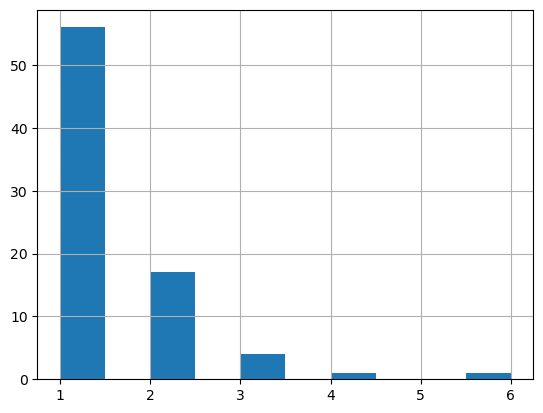

In [387]:
huh['run_length'].hist()

In [392]:
(prev_own_runs.groupby('run_id_gp').size()).mean()

np.float64(1.0)

In [395]:
prev_opponent_runs.groupby('run_id_gp').size()

run_id_gp
9     1
11    1
13    1
15    1
17    1
19    1
dtype: int64

In [396]:
prev_opponent_runs

,GAME_ID,gp,run_id_gp,home_team,away_team_team,run_length,run_team,previous_run_team,home_score,away_score,home_to,away_to,home_to_index,away_to_index,start_time,end_time,next_run_length,next_home_score,next_away_score,previous_run_length,previous_home_score,previous_away_score,home_net_diff,away_net_diff,run_time
67,0062300001,00623000014,9,LAL,IND,1,LAL,IND,102.0,96.0,0,0,0,0,400,399,1,102,99,1,100,96,6.0,-6.0,29
69,0062300001,00623000014,11,LAL,IND,6,LAL,IND,115.0,99.0,1,1,1,5,350,191,1,115,102,1,102,99,16.0,-16.0,189
71,0062300001,00623000014,13,LAL,IND,1,LAL,IND,117.0,102.0,0,0,0,0,146,146,1,117,104,1,115,102,15.0,-15.0,9
73,0062300001,00623000014,15,LAL,IND,1,LAL,IND,118.0,104.0,0,0,0,0,133,133,1,118,106,1,117,104,14.0,-14.0,8
75,0062300001,00623000014,17,LAL,IND,1,LAL,IND,121.0,106.0,0,0,0,0,112,112,1,121,108,1,118,106,15.0,-15.0,7
77,0062300001,00623000014,19,LAL,IND,1,LAL,IND,123.0,108.0,0,0,0,0,94,94,1,123,109,1,121,108,15.0,-15.0,62


In [391]:
for ix,group in huh.groupby(['GAME_ID','gp', 'run_id_gp']):
    run_id = group['run_id_gp'].iloc[0] 
    run_team = group['run_team'].iloc[0] 
    previous_5_runs_own = [run_id-i for i in range(2, 14,2)]
    previous_5_runs_opponent = [run_id-i for i in range(1, 12,2)]
    # Get the previous 5 runs by the same team and opponent
    prev_own_runs = huh[(huh['gp'] == gp) & (huh['run_team'] == run_team) & (huh['run_id_gp'].isin(previous_5_runs_own))]
    prev_opponent_runs = huh[(huh['gp'] == gp) & (huh['run_team'] != run_team) & (huh['run_id_gp'].isin(previous_5_runs_opponent))]

    if not prev_own_runs.empty:
        avg_own_run_length = (prev_own_runs['run_length'].mean()
        own_run_length_max = (prev_own_runs['run_length'].max()
        own_run_length_min = (prev_own_runs['run_length'].min()
    else:
        avg_own_run_length, own_run_length_max, own_run_length_min = None, None, None

    if not prev_opponent_runs.empty:
        avg_opponent_run_length = (prev_opponent_runs['run_length'].mean()
        opponent_run_length_max = (prev_opponent_runs['run_length'].max()
        opponent_run_length_min = (prev_opponent_runs['run_length'].min()
    else:
        avg_opponent_run_length, opponent_run_length_max, opponent_run_length_min = None, None, None
        
    dict_all_runs['avg_opponent_run_length'].append(avg_opponent_run_length)
    dict_all_runs['opponent_run_length_max'].append(opponent_run_length_max)
    dict_all_runs['opponent_run_length_min'].append(opponent_run_length_min)
    dict_all_runs['avg_own_run_length'].append(avg_own_run_length)
    dict_all_runs['own_run_length_max'].append(own_run_length_max)
    dict_all_runs['own_run_length_min'].append(own_run_length_min)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [382]:
pd.DataFrame(dict_all_runs).max()

avg_opponent_run_length    1.0
opponent_run_length_max    1.0
opponent_run_length_min    1.0
avg_own_run_length         1.0
own_run_length_max         1.0
own_run_length_min         1.0
dtype: float64

In [305]:
all_runs_to[all_runs_to['gp']=='00623000011'].columns

Index(['run_id_gp', 'gp', 'home_team', 'away_team', 'home_score', 'away_score',
       'run_length', 'to', 'home_to', 'away_to', 'to_index', 'changed_run',
       'run_team', 'next_run_length', 'next_run_home_score',
       'next_run_away_score', 'next_run_team', 'previous_run_length',
       'previous_run_home_score', 'previous_run_away_score',
       'previous_run_team', 'avg_opponent_run_length',
       'opponent_run_length_max', 'opponent_run_length_min',
       'avg_own_run_length', 'own_run_length_max', 'own_run_length_min',
       'to_team', 'to_non_run', 'previous_run_time', 'last_run_time',
       'time_spent_run', 'to_time', 'net_diff_home', 'net_diff_away',
       'scoring_ratio', 'Season', 'GAME_ID'],
      dtype='object')

In [132]:
all_runs_23[all_runs_23['gp']=='623000011']

,run_id_gp,gp,home_team,away_team,home_score,away_score,run_team,run_length,to,home_to,away_to,to_index,changed_run,next_run_team,next_run_length,next_run_home_score,next_run_away_score,previous_run_team,previous_run_length,previous_run_home_score,previous_run_away_score,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,net_diff,to_team,to_non_run,previous_run_time,last_run_time,time_spent_run,to_time,GAME_ID
90859,2,623000011,Lakers,Pacers,0.0,3.0,Pacers,1,0,0,0,0,0,Lakers,1,2.0,3.0,NaN,0,0.0,0.0,0.0,0,0,0.0,0,0,3.0,NaN,NaN,720,698,22,NaN,0062300001
90860,3,623000011,Lakers,Pacers,2.0,3.0,Lakers,1,0,0,0,0,0,Pacers,1,2.0,5.0,Pacers,1,0.0,3.0,1.0,1,1,0.0,0,0,2.0,NaN,NaN,698,681,17,NaN,0062300001
90861,4,623000011,Lakers,Pacers,2.0,5.0,Pacers,1,0,0,0,0,0,Lakers,4,9.0,5.0,Lakers,1,2.0,3.0,1.0,1,1,1.0,1,1,2.0,NaN,NaN,681,663,18,NaN,0062300001
90862,5,623000011,Lakers,Pacers,9.0,5.0,Lakers,4,0,0,0,0,0,Pacers,1,9.0,8.0,Pacers,1,2.0,5.0,1.0,1,1,1.0,1,1,7.0,NaN,NaN,663,547,116,NaN,0062300001
90863,6,623000011,Lakers,Pacers,9.0,8.0,Pacers,1,0,0,0,0,0,Lakers,1,11.0,8.0,Lakers,4,9.0,5.0,2.5,4,1,1.0,1,1,3.0,NaN,NaN,547,529,18,NaN,0062300001
90864,7,623000011,Lakers,Pacers,11.0,8.0,Lakers,1,0,0,0,0,0,Pacers,1,11.0,11.0,Pacers,1,9.0,8.0,1.0,1,1,2.5,4,1,2.0,NaN,NaN,529,515,14,NaN,0062300001
90865,8,623000011,Lakers,Pacers,11.0,11.0,Pacers,1,0,0,0,0,0,Lakers,2,15.0,11.0,Lakers,1,11.0,8.0,2.0,4,1,1.0,1,1,3.0,NaN,NaN,515,500,15,NaN,0062300001
90866,9,623000011,Lakers,Pacers,15.0,11.0,Lakers,2,0,0,0,0,0,Pacers,1,15.0,13.0,Pacers,1,11.0,11.0,1.0,1,1,2.0,4,1,4.0,NaN,NaN,500,449,51,NaN,0062300001
90867,10,623000011,Lakers,Pacers,15.0,13.0,Pacers,1,1,1,0,0,1,Lakers,2,20.0,13.0,Lakers,2,15.0,11.0,2.0,4,1,1.0,1,1,-2.0,Lakers,1.0,449,432,17,431.0,0062300001
90868,11,623000011,Lakers,Pacers,20.0,13.0,Lakers,2,0,0,0,0,0,Pacers,1,20.0,15.0,Pacers,1,15.0,13.0,1.0,1,1,2.0,4,1,5.0,NaN,NaN,432,392,40,NaN,0062300001


In [130]:
all_runs_to[all_runs_to['gp']=='00623000011']

,run_id_gp,gp,home_team,away_team,home_score,away_score,run_length,to,home_to,away_to,to_index,changed_run,run_team,next_run_length,next_run_home_score,next_run_away_score,next_run_team,previous_run_length,previous_run_home_score,previous_run_away_score,previous_run_team,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,to_team,to_non_run,previous_run_time,last_run_time,time_spent_run,to_time,net_diff_home,net_diff_away,scoring_ratio,Season,GAME_ID
380154,2,00623000011,LAL,IND,5.0,5.0,4,0,0,0,0,0,IND,1,7.0,5.0,LAL,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720,633,87,NaN,0.0,0.0,0.000000,23,0062300001
380155,3,00623000011,LAL,IND,7.0,5.0,1,0,0,0,0,0,LAL,1,9.0,8.0,IND,4,5.0,5.0,IND,2.000000,2.0,2.0,NaN,NaN,NaN,NaN,NaN,633,599,34,NaN,2.0,-2.0,0.058824,23,0062300001
380156,4,00623000011,LAL,IND,9.0,8.0,1,0,0,0,0,0,IND,2,11.0,11.0,LAL,1,7.0,5.0,LAL,1.000000,1.0,1.0,2.000000,2.0,2.0,NaN,NaN,599,529,70,NaN,-1.0,1.0,-0.014286,23,0062300001
380157,5,00623000011,LAL,IND,11.0,11.0,2,0,0,0,0,0,LAL,2,13.0,11.0,LAL,1,9.0,8.0,IND,1.500000,2.0,1.0,1.000000,1.0,1.0,NaN,NaN,529,500,29,NaN,-1.0,1.0,-0.034483,23,0062300001
380158,6,00623000011,LAL,IND,13.0,11.0,2,0,0,0,0,0,LAL,2,15.0,12.0,LAL,2,11.0,11.0,LAL,1.000000,1.0,1.0,2.000000,2.0,2.0,NaN,NaN,500,481,19,NaN,2.0,-2.0,0.105263,23,0062300001
380159,7,00623000011,LAL,IND,15.0,12.0,2,1,1,0,1,1,LAL,2,17.0,13.0,IND,2,13.0,11.0,LAL,1.500000,2.0,1.0,1.000000,1.0,1.0,LAL,0.0,481,432,49,431.0,1.0,-1.0,0.020408,23,0062300001
380160,8,00623000011,LAL,IND,17.0,13.0,2,0,0,0,0,0,IND,2,20.0,15.0,LAL,2,15.0,12.0,LAL,1.000000,1.0,1.0,1.500000,2.0,1.0,NaN,NaN,432,415,17,NaN,1.0,-1.0,0.058824,23,0062300001
380161,9,00623000011,LAL,IND,20.0,15.0,2,0,0,0,0,0,LAL,1,22.0,15.0,LAL,2,17.0,13.0,IND,1.333333,2.0,1.0,1.000000,1.0,1.0,NaN,NaN,415,371,44,NaN,1.0,-1.0,0.022727,23,0062300001
380162,10,00623000011,LAL,IND,22.0,15.0,1,0,0,0,0,0,LAL,1,22.0,17.0,IND,2,20.0,15.0,LAL,1.000000,1.0,1.0,1.666667,2.0,1.0,NaN,NaN,371,333,38,NaN,2.0,-2.0,0.052632,23,0062300001
380163,11,00623000011,LAL,IND,22.0,17.0,1,0,0,0,0,0,IND,1,24.0,17.0,LAL,1,22.0,15.0,LAL,1.500000,2.0,1.0,1.000000,1.0,1.0,NaN,NaN,333,291,42,NaN,-2.0,2.0,-0.047619,23,0062300001


In [70]:
dict_all_runs = {
    'run_id_gp': [],
    'gp': [],
    'home_team': [],
    'away_team': [],
    'home_score': [],
    'away_score': [],
    'run_length': [],
    'to': [],
    'home_to': [],
    'away_to': [],
    'to_index': [],
    'changed_run': [],
    'run_team': [],
    'next_run_length': [],
    'next_run_home_score': [],
    'next_run_away_score': [],
    'next_run_team': [],
    'previous_run_length': [],
    'previous_run_home_score': [],
    'previous_run_away_score': [],
    'previous_run_team': [],
    'avg_opponent_run_length': [],
    'opponent_run_length_max': [],
    'opponent_run_length_min': [],
    'avg_own_run_length': [],
    'own_run_length_max': [],
    'own_run_length_min': [],
    'to_team': []
}

for ix, group in tqdm(possession_summary.groupby(['gp', 'run_id_gp'])):
    run_id = group['run_id_gp'].iloc[0]
    gp = group['gp'].iloc[0]
    home_team = group['HomeName'].iloc[0]
    away_team = group['AwayName'].iloc[0]
    home_score = group['end_home_score'].iloc[-1]
    away_score = group['end_away_score'].iloc[-1]
    run_length = group.shape[0]
    run_team = group['possession'].transform(getmode).iloc[0]
    previous_run_team = group['defense'].transform(getmode).iloc[0]
    gp_int = int(gp)
    # Calculate timeouts and run changes
    if True in group['home_timeout_after'].values:
        to = 1
        home_to = 1
        away_to = 0
        to_list = group['home_timeout_after'].to_list()
        true_index = to_list.index(True)
        if true_index + 1 == run_length:
            changed_run = 1
        timeout = 'home'
    elif True in group['away_timeout_after'].values:
        to = 1
        home_to = 0
        away_to = 1
        to_list = group['away_timeout_after'].to_list()
        true_index = to_list.index(True)
        if true_index + 1 == run_length:
            changed_run = 1
        timeout = 'away'
    else:
        to, home_to, away_to, true_index, changed_run = 0, 0, 0, 0, 0
        timeout = np.nan

    # Find next and previous runs within the same game-period (gp)
    next_run = runs[(runs['gp'] == gp) & (runs['run_id_gp'] == run_id + 1)]
    prev_run = runs[(runs['gp'] == gp) & (runs['run_id_gp'] == run_id - 1)]

    if not next_run.empty:
        next_run_length = next_run.shape[0]
        next_run_home_score = next_run['end_home_score'].iloc[-1]
        next_run_away_score = next_run['end_away_score'].iloc[-1]
        next_run_team = next_run['offense'].iloc[0]
    else:
        try:
            next_gp = str(gp_int + 1).zfill(11)
            next_run = runs[(runs['gp'] == next_gp)]
            next_run = next_run[next_run['run_id_gp'] == next_run['run_id_gp'].min()]
            next_run_length = next_run.shape[0]
            next_run_home_score = next_run['end_home_score'].iloc[-1]
            next_run_away_score = next_run['end_away_score'].iloc[-1]
            next_run_team = next_run['offense'].iloc[0]
        except:
            next_run_length, next_run_home_score, next_run_away_score, next_run_team = 0, 0, 0, np.nan

    if not prev_run.empty:
        previous_run_length = prev_run.shape[0]
        previous_run_home_score = prev_run['end_home_score'].iloc[-1]
        previous_run_away_score = prev_run['end_away_score'].iloc[-1]
        previous_run_team = prev_run['offense'].iloc[0]
    else:
        try:
            prev_gp = str(gp_int - 1).zfill(11)
            previous_run = runs[(runs['gp'] == prev_gp)]
            previous_run = previous_run[previous_run['run_id_gp'] == previous_run['run_id_gp'].max()]
            previous_run_length = previous_run.shape[0]
            previous_run_home_score = previous_run['end_home_score'].iloc[-1]
            previous_run_away_score = previous_run['end_away_score'].iloc[-1]
            previous_run_team = previous_run['offense'].iloc[0]
        except:
            previous_run_length, previous_run_home_score, previous_run_away_score, previous_run_team = 0, 0, 0, np.nan
    previous_5_runs_own = [run_id-i for i in range(2, 14,2)]
    previous_5_runs_opponent = [run_id-i for i in range(1, 12,2)]
    # Get the previous 5 runs by the same team and opponent
    prev_own_runs = runs[(runs['gp'] == gp) & (runs['offense'] == run_team) & (runs['run_id_gp'].isin(previous_5_runs_own))]
    prev_opponent_runs = runs[(runs['gp'] == gp) & (runs['offense'] != run_team) & (runs['run_id_gp'].isin(previous_5_runs_opponent))]

    if not prev_own_runs.empty:
        avg_own_run_length = (prev_own_runs.groupby('run_id_gp').size()).mean()
        own_run_length_max = (prev_own_runs.groupby('run_id_gp').size()).max()
        own_run_length_min = (prev_own_runs.groupby('run_id_gp').size()).min()
    else:
        avg_own_run_length, own_run_length_max, own_run_length_min = None, None, None

    if not prev_opponent_runs.empty:
        avg_opponent_run_length = (prev_opponent_runs.groupby('run_id_gp').size()).mean()
        opponent_run_length_max = (prev_opponent_runs.groupby('run_id_gp').size()).max()
        opponent_run_length_min = (prev_opponent_runs.groupby('run_id_gp').size()).min()
    else:
        avg_opponent_run_length, opponent_run_length_max, opponent_run_length_min = None, None, None
    if timeout == 'home':
        to_team = home_team
    elif timeout == 'away':
        to_team = away_team
    else:
        to_team = np.nan
    # Append values to the dictionary during your analysis
    dict_all_runs['run_id_gp'].append(run_id)
    dict_all_runs['gp'].append(gp)
    dict_all_runs['home_team'].append(home_team)
    dict_all_runs['away_team'].append(away_team)
    dict_all_runs['home_score'].append(home_score)
    dict_all_runs['away_score'].append(away_score)
    dict_all_runs['run_team'].append(run_team)
    dict_all_runs['run_length'].append(run_length)
    dict_all_runs['to'].append(to)
    dict_all_runs['home_to'].append(home_to)
    dict_all_runs['away_to'].append(away_to)
    dict_all_runs['to_index'].append(true_index)
    dict_all_runs['changed_run'].append(changed_run)
    dict_all_runs['next_run_length'].append(next_run_length)
    dict_all_runs['next_run_home_score'].append(next_run_home_score)
    dict_all_runs['next_run_away_score'].append(next_run_away_score)
    dict_all_runs['next_run_team'].append(next_run_team)
    dict_all_runs['previous_run_length'].append(previous_run_length)
    dict_all_runs['previous_run_home_score'].append(previous_run_home_score)
    dict_all_runs['previous_run_away_score'].append(previous_run_away_score)
    dict_all_runs['previous_run_team'].append(previous_run_team)
    dict_all_runs['avg_opponent_run_length'].append(avg_opponent_run_length)
    dict_all_runs['opponent_run_length_max'].append(opponent_run_length_max)
    dict_all_runs['opponent_run_length_min'].append(opponent_run_length_min)
    dict_all_runs['avg_own_run_length'].append(avg_own_run_length)
    dict_all_runs['own_run_length_max'].append(own_run_length_max)
    dict_all_runs['own_run_length_min'].append(own_run_length_min)
    dict_all_runs['to_team'].append(to_team)

  0%|          | 0/40 [00:00<?, ?it/s]

In [71]:
test = pd.DataFrame(dict_all_runs)

In [72]:
test[test['to']==1]

,run_id_gp,gp,home_team,away_team,home_score,away_score,run_length,to,home_to,away_to,to_index,changed_run,run_team,next_run_length,next_run_home_score,next_run_away_score,next_run_team,previous_run_length,previous_run_home_score,previous_run_away_score,previous_run_team,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,to_team
6,8,00623000011,LAL,IND,28.0,23.0,2,1,0,1,1,1,LAL,3,15.0,11.0,LAL,1,9.0,5.0,LAL,1.333333,2.0,1.0,None,None,None,IND
7,9,00623000011,LAL,IND,29.0,23.0,7,1,1,0,0,1,IND,2,15.0,13.0,IND,1,11.0,11.0,IND,1.000000,1.0,1.0,None,None,None,LAL
12,2,00623000012,LAL,IND,52.0,45.0,3,1,0,1,2,1,IND,2,38.0,33.0,LAL,2,34.0,29.0,LAL,NaN,NaN,NaN,None,None,None,IND
15,5,00623000012,LAL,IND,52.0,49.0,6,1,1,0,5,1,LAL,2,40.0,38.0,IND,1,38.0,36.0,IND,1.500000,2.0,1.0,None,None,None,LAL
26,5,00623000013,LAL,IND,84.0,73.0,5,1,0,1,0,0,LAL,3,70.0,60.0,LAL,3,90.0,79.0,LAL,3.000000,3.0,3.0,None,None,None,IND
31,10,00623000013,LAL,IND,90.0,79.0,7,1,1,0,2,0,IND,2,74.0,67.0,IND,1,72.0,63.0,IND,1.250000,2.0,1.0,None,None,None,LAL
35,4,00623000014,LAL,IND,115.0,99.0,9,1,1,0,2,0,IND,1,94.0,91.0,IND,3,92.0,89.0,IND,3.000000,3.0,3.0,None,None,None,LAL
37,6,00623000014,LAL,IND,123.0,108.0,5,1,1,0,4,1,LAL,2,100.0,96.0,IND,1,94.0,91.0,IND,2.000000,3.0,1.0,None,None,None,LAL
39,8,00623000014,LAL,IND,123.0,109.0,16,1,1,0,14,0,LAL,1,102.0,99.0,IND,2,100.0,96.0,IND,2.000000,3.0,1.0,None,None,None,LAL


In [55]:
test.sum(numeric_only=True)

run_id_gp                   281.0
home_score                 1357.0
away_score                 1207.0
run_length                  220.0
to                            8.0
home_to                       6.0
away_to                       2.0
to_index                     30.0
changed_run                   3.0
next_run_length              67.0
next_run_home_score        2136.0
next_run_away_score        1921.0
previous_run_length          67.0
previous_run_home_score    2018.0
previous_run_away_score    1813.0
avg_opponent_run_length      63.5
opponent_run_length_max      81.0
opponent_run_length_min      48.0
dtype: float64

In [362]:
all_runs_to[all_runs_to['gp'].isin(['00623000011','00623000012','00623000013','00623000014'])].sum(numeric_only=True)

run_id_gp                    669.000000
home_score                  4121.000000
away_score                  3709.000000
run_length                   126.000000
to                             8.000000
home_to                        3.000000
away_to                        5.000000
to_index                      11.000000
changed_run                    5.000000
next_run_length              122.000000
next_run_home_score         4116.000000
next_run_away_score         3704.000000
previous_run_length          125.000000
previous_run_home_score     3998.000000
previous_run_away_score     3600.000000
avg_opponent_run_length       90.433333
opponent_run_length_max      121.000000
opponent_run_length_min       71.000000
avg_own_run_length            86.133333
own_run_length_max           112.000000
own_run_length_min            71.000000
to_non_run                     6.000000
previous_run_time          23870.000000
last_run_time              21273.000000
time_spent_run              2597.000000


In [354]:
all_runs_23[all_runs_23['GAME_ID']=='0062300001'].sum(numeric_only=True)

run_id_gp                    679.00
home_score                  2734.00
away_score                  2428.00
run_length                    84.00
to                             7.00
home_to                        2.00
away_to                        5.00
to_index                       4.00
changed_run                    6.00
next_run_length               79.00
next_run_home_score         2819.00
next_run_away_score         2503.00
previous_run_length           80.00
previous_run_home_score     2545.00
previous_run_away_score     2257.00
avg_opponent_run_length       79.95
opponent_run_length_max      119.00
opponent_run_length_min       59.00
avg_own_run_length            75.55
own_run_length_max           112.00
own_run_length_min            56.00
net_diff                     135.00
to_non_run                     7.00
previous_run_time          22105.00
last_run_time              19964.00
time_spent_run              2141.00
to_time                     2611.00
dtype: float64

In [331]:
runs_23[runs_23['GAME_ID']=='0062300001']

,GAME_ID,PERIOD,HomeName,AwayName,possession_id,possession,start,end,end_home_score,end_away_score,home_timeout_after,away_timeout_after,last_event,score,last_score,home_poss,offense,defense,gp,run_id,run_id_gp,to_start
263515,0062300001,1,Lakers,Pacers,1,Lakers,705,720,0.0,0.0,False,False,B. Brown BLOCK (1 BLK),False,Kings,True,Lakers,Pacers,00623000011,2,2,704
263516,0062300001,1,Lakers,Pacers,2,Pacers,698,701,0.0,3.0,False,False,Hield 3PT Running Jump Shot (3 PTS) (Haliburto...,True,Kings,False,Pacers,Lakers,00623000011,3,3,697
263517,0062300001,1,Lakers,Pacers,3,Lakers,681,681,2.0,3.0,False,False,Reddish 4' Driving Finger Roll Layup (2 PTS) (...,True,Pacers,True,Lakers,Pacers,00623000011,4,4,680
263518,0062300001,1,Lakers,Pacers,4,Pacers,663,663,2.0,5.0,False,False,Toppin 2' Driving Layup (2 PTS) (Hield 1 AST),True,Lakers,False,Pacers,Lakers,00623000011,5,5,662
263519,0062300001,1,Lakers,Pacers,5,Lakers,651,651,3.0,5.0,False,False,Russell Free Throw 2 of 2 (1 PTS),True,Pacers,True,Lakers,Pacers,00623000011,6,6,650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263722,0062300001,4,Lakers,Pacers,207,Lakers,94,94,123.0,108.0,False,False,Davis 1' Cutting Dunk Shot (41 PTS) (Russell 7...,True,Pacers,True,Lakers,Pacers,00623000014,208,44,93
263723,0062300001,4,Lakers,Pacers,208,Pacers,73,87,0.0,0.0,False,False,MISS Haliburton 29' 3PT Pullup Jump Shot,False,Lakers,False,Pacers,Lakers,00623000014,209,45,72
263724,0062300001,4,Lakers,Pacers,209,Lakers,46,70,0.0,0.0,False,True,LAKERS Turnover: Shot Clock (T#19),False,Lakers,True,Lakers,Pacers,00623000014,210,46,45
263725,0062300001,4,Lakers,Pacers,210,Pacers,29,32,123.0,109.0,False,False,Tshiebwe Free Throw 2 of 2 (1 PTS),True,Lakers,False,Pacers,Lakers,00623000014,211,47,28


In [13]:
# Loop through window sizes from 2 to 5 for backward-looking averages
for i in range(2, 6):
    all_runs_to[f'avg_{i}_scoring_ratio'] = (
        all_runs_to.groupby('gp')['scoring_ratio']
        .rolling(window=i, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# Create shifted columns for forward-looking sums
for shift in range(1, 6):
    all_runs_to[f'shift_-{shift}_scoring_ratio'] = all_runs_to.groupby('gp')['scoring_ratio'].shift(-shift)

# Calculate the forward-looking averages for the next 1 to 5 runs
for i in range(1, 6):
    # Forward-looking average for 'scoring_ratio'
    all_runs_to[f'next_{i}_avg_scoring_ratio'] = (
        sum(all_runs_to[f'shift_-{shift}_scoring_ratio'] for shift in range(1, i+1)) / i
    ).fillna(method='ffill')

# Drop the intermediate shifted columns if no longer needed
all_runs_to.drop(columns=[f'shift_-{shift}_scoring_ratio' for shift in range(1, 6)], inplace=True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_3968\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_3968\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_3968\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_3968\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_3968\4017142516.py:19: FutureWarning: Series.fil

In [14]:
all_runs_to['run_length_continued'] = all_runs_to['run_length'] - (all_runs_to['to_index'] + 1)

In [15]:
df_analysis = all_runs_to.copy()

In [16]:
model_cols = [x for x in df_analysis.columns if 'next' not in x and 'scoring_ratio' in x]
model_cols_2 = ['avg_opponent_run_length', 'opponent_run_length_max',
       'opponent_run_length_min', 'avg_own_run_length', 'own_run_length_max',
       'own_run_length_min', 'net_diff_home','net_diff_away','next_3_avg_scoring_ratio','previous_run_time', 'last_run_time', 'time_spent_run', 'to_time','Season']
model_cols = model_cols + model_cols_2

In [17]:
to_df = df_analysis[(df_analysis['to_non_run']==1)][model_cols]

In [18]:
X = to_df.drop(['next_3_avg_scoring_ratio','Season'],axis=1)

In [19]:
X.fillna(0,inplace=True)

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=3)
pca_components = pca.fit_transform(X_scaled)

In [21]:
pca_components_df = pd.DataFrame(pca_components,columns=['PC1','PC2','PC3'])
pca_components_df['home_to'] = df_analysis[(df_analysis['to_non_run']==1)]['home_to'].values

In [22]:
pca_components_df['next_3_avg_scoring_ratio'] = df_analysis[(df_analysis['to_non_run']==1)]['next_3_avg_scoring_ratio'].values
pca_components_df['Season'] = (df_analysis[(df_analysis['to_non_run']==1)]['Season'].values).astype(int)

In [23]:
train_df = pca_components_df[pca_components_df['Season']<23]
test_df = pca_components_df[pca_components_df['Season']==23]

In [24]:
assert len(df_analysis[(df_analysis['to_non_run']==1)]) == len(train_df) + len(test_df)

In [25]:
X_train = train_df.drop(['Season','next_3_avg_scoring_ratio'],axis=1)
y_train = train_df['next_3_avg_scoring_ratio']
X_test = test_df.drop(['Season','next_3_avg_scoring_ratio'],axis=1)
y_test = test_df['next_3_avg_scoring_ratio']

In [26]:
# # Define the objective function
# def objective(trial):
#     # Suggest hyperparameters
#     max_basis = trial.suggest_int('max_basis', 30, 70)
#     basis_system = trial.suggest_categorical('basis_system', ['cosine'])
    
#     n_estimators = trial.suggest_int('n_estimators', 10, 1500)
#     learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1,log=True)
#     max_depth = trial.suggest_int('max_depth', 3, 10)
    
#     # Parameterize the model with the suggested hyperparameters
#     model = flexcode.FlexCodeModel(
#         XGBoost,
#         max_basis=max_basis,
#         basis_system=basis_system,
#         regression_params={
#             'n_estimators': n_estimators,
#             'learning_rate': learning_rate,
#             'max_depth': max_depth
#         }
#     )
    
#     # Fit the model
#     model.fit(X_train.values, y_train.values)
    
#     # Evaluate the model
#     cde_loss = np.abs(model.estimate_error(X_test.values, y_test.values, n_grid=1000))
    
#     return cde_loss

# # Create the Optuna study and optimize
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# # Print the best hyperparameters
# print("Best hyperparameters: ", study.best_params)

# # Train the final model with the best hyperparameters
# best_params = study.best_params
# final_model = flexcode.FlexCodeModel(
#     XGBoost,
#     max_basis=best_params['max_basis'],
#     basis_system=best_params['basis_system'],
#     regression_params={
#         'n_estimators': best_params['n_estimators'],
#         'learning_rate': best_params['learning_rate'],
#         'max_depth': best_params['max_depth']
#     }
# )
# final_model.fit(X_train.values, y_train.values)

# # Evaluate the final model
# final_cde_loss = final_model.estimate_error(X_test.values, y_test.values, n_grid=1000)
# print("Final Model CDE Loss: ", final_cde_loss)

In [27]:
#{'max_basis': 68, 'basis_system': 'cosine', 'n_estimators': 499, 'learning_rate': 0.09978082774194517, 'max_depth': 10}
#{'max_basis': 64, 'basis_system': 'cosine', 'n_estimators': 1149, 'learning_rate': 0.06162001801080429, 'max_depth': 9}
#'n_estimators': 1309, 'learning_rate': 0.09865765655385056, 'max_depth': 8}

Average Log-Likelihood: -4.223478510346469
RMSE for Conditional Mean: 0.08966331677159187
RMSE for Conditional Standard Deviation: 0.19221321510901432


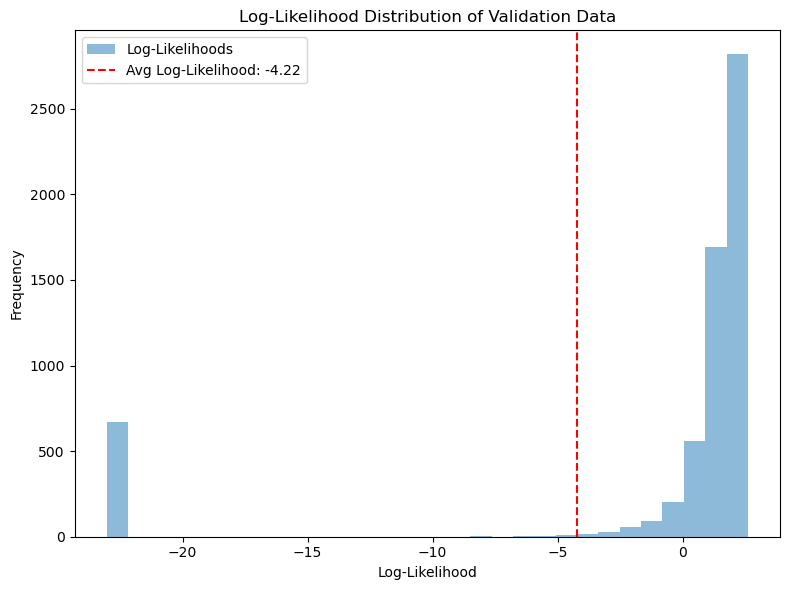

In [28]:
# Parameterize and fit the FlexCode model
model = flexcode.FlexCodeModel(XGBoost, max_basis=64, basis_system="cosine",
                               regression_params={'n_estimators': 1470, 'learning_rate': 0.0808881770364235, 'max_depth': 10})
model.fit(X_train.values, y_train.values)

#Predict conditional densities and y grid using the model for validation set
cdes, y_grid_flexcode = model.predict(X_test.values, n_grid=1000)
y_grid_flexcode = y_grid_flexcode.reshape(-1)

# Define function to calculate the expectation (mean) and standard deviation of the estimated distribution
def conditional_mean_std(cde, y_grid):
    mean_est = np.sum(y_grid * cde) / np.sum(cde)  # Mean as the weighted average
    std_est = np.sqrt(np.sum(((y_grid - mean_est) ** 2) * cde) / np.sum(cde))  # Std deviation
    return mean_est, std_est

# Calculate metrics
log_likelihoods = []
rmse_means = []
rmse_stds = []

epsilon = 1e-10  # Small value to avoid log(0)

# Iterate over validation set
for i in range(len(X_test)):
    y_value = y_test.values[i]
    cde = cdes[i]

    # Calculate conditional mean and standard deviation for the estimated distribution
    mean_est, std_est = conditional_mean_std(cde, y_grid_flexcode)

    # Calculate log-likelihood with epsilon to avoid log(0)
    interpolated_density = np.interp(y_value, y_grid_flexcode, cde, left=0, right=0) + epsilon
    log_likelihood = np.log(interpolated_density)
    log_likelihoods.append(log_likelihood)

    # Calculate RMSE for mean
    rmse_mean = (y_value - mean_est) ** 2
    rmse_means.append(rmse_mean)

    # Calculate RMSE for standard deviation
    rmse_std = ((abs(y_value - mean_est) - std_est) ** 2)
    rmse_stds.append(rmse_std)

# Average log-likelihood
avg_log_likelihood = model.estimate_error(X_test.values, y_test.values)

# RMSE for mean
rmse_mean = np.sqrt(np.mean(rmse_means))

# RMSE for standard deviation
rmse_std = np.sqrt(np.mean(rmse_stds))

print("Average Log-Likelihood:", avg_log_likelihood)
print("RMSE for Conditional Mean:", rmse_mean)
print("RMSE for Conditional Standard Deviation:", rmse_std)

# Plotting the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(log_likelihoods, bins=30, alpha=0.5, label='Log-Likelihoods')
ax.axvline(avg_log_likelihood, color='r', linestyle='--', label=f'Avg Log-Likelihood: {avg_log_likelihood:.2f}')
ax.set_title("Log-Likelihood Distribution of Validation Data")
ax.set_xlabel("Log-Likelihood")
ax.set_ylabel("Frequency")
ax.legend()
plt.tight_layout()
plt.show()
# Average Log-Likelihood: -0.32862157953660187
# RMSE for Conditional Mean: 0.05549503556260016
# RMSE for Conditional Standard Deviation: 0.09122680736668978

c:\Users\isaac\.conda\envs\timeout_analysis\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
crystalball,5.458627,1472.131128,1498.117457,inf,0.019256,0.052220
norm,7.372443,3294.858458,3307.851622,inf,0.031258,0.000136
pearson3,7.377283,3124.683794,3144.173540,inf,0.031615,0.000109
lognorm,7.378784,3329.503320,3348.993067,inf,0.031485,0.000119
t,9.231891,1013.272280,1032.762026,inf,0.026162,0.002406


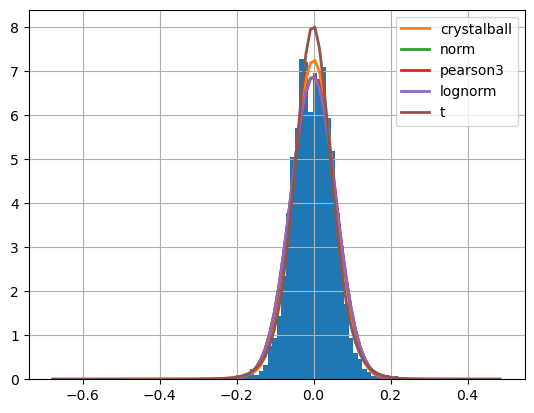

In [94]:
f = Fitter(y_train.values,distributions=['crystalball','expon','gamma','lognorm','norm','pearson3','triang','uniform','weibull_min','weibull_max',
                                         'logistic','t'])
f.fit()
f.summary()

In [29]:
cdes, y_grid_flexcode = model.predict(X_test.values, n_grid=1000)

In [30]:
# Function to calculate the conditional mean (expected value)
def conditional_mean(cde, y_grid):
    mean_est = np.round(np.sum(y_grid * cde) / np.sum(cde),4)  # Mean as the weighted average
    return mean_est

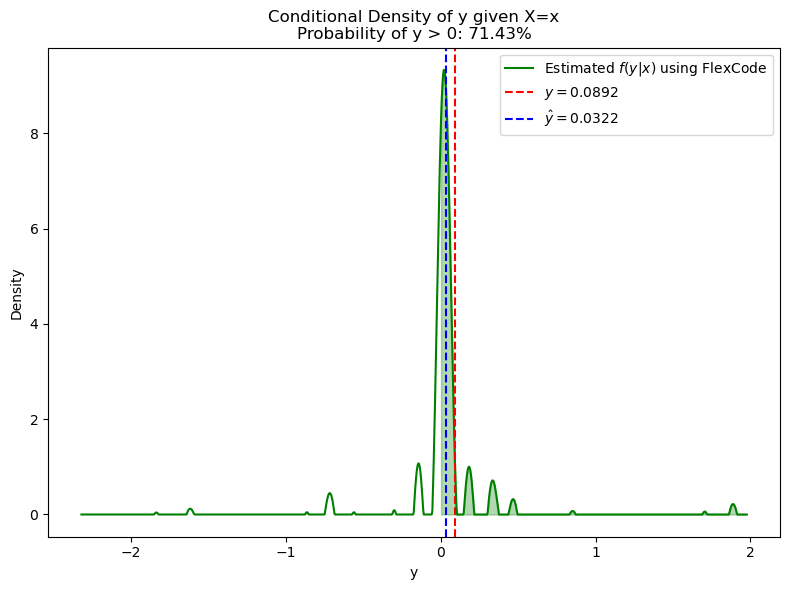

In [31]:
# Define the range for y values based on your data
y_grid_refined = np.linspace(y_test.min(), y_test.max(), 1000)
y_grid_flexcode = y_grid_flexcode.ravel()
# Plotting setup
fig, ax = plt.subplots(figsize=(8, 6))
beta, m = 1, 2

# Iterate over a few random samples for visualization
for c, sample_index in enumerate(np.random.RandomState().choice(len(X_test), size=1, replace=False)):
    y_value = np.round(y_test.values[sample_index], 4)
    
    # Calculate PDF of crystalball distribution for the given y_value
    pdf_logistic = stats.crystalball.pdf(y_grid_refined, loc=y_value, scale=0.02, beta=beta, m=m)
    cde = cdes[sample_index]
    cde_df = pd.DataFrame([cde, y_grid_flexcode]).T
    cde_df.columns = ['cde', 'y_grid_flexcode']
    
    # Plot real conditional density (logistic distribution)
    # ax.plot(y_grid_refined, pdf_logistic, "--", color=f"blue", label=f"Real $f(y | x = {y_value})$ Logistic")
    
    # Plot estimated CDE using FlexCode model
    ax.plot(y_grid_flexcode, cde, color=f"green", label=f"Estimated $f(y | x)$ using FlexCode")
    
    # Shade the area where y > 0 for the FlexCode model CDE
    ax.fill_between(y_grid_flexcode, 0, cde, where=(y_grid_flexcode > 0), color=f"green", alpha=0.3)
    #ax.fill_between(y_grid_flexcode, 0, cde, where=(cde >= q1) & (cde <= q3), color="green", alpha=0.3, label=f"Q1-Q3 range {q1} - {q3} ")
    
    # Highlight the actual y value with a vertical line
    ax.axvline(y_value, color="red", linestyle="--", label=f"$y = {y_value}$")
    
    # Calculate conditional mean
    y_hat = round(float(np.sum(cde_df['cde'] * cde_df['y_grid_flexcode'])/np.sum(cde_df['cde'])),4)
    
    # Highlight the conditional mean y_hat with a vertical line
    ax.axvline(y_hat, color="blue", linestyle="--", label=rf"$\hat{{y}} = {y_hat}$")
    
    # Calculate positive probability
    positive_prob = np.round((cde_df[(cde_df['cde']>0)&(cde_df['y_grid_flexcode']>0)]['cde'].sum()/cde_df['cde'].sum())*100, 2)
# Set plot labels and title
ax.set_title("Conditional Density of y given X=x\n" + f"Probability of y > 0: {positive_prob}%")
ax.set_xlabel("y")
ax.set_ylabel("Density")
ax.legend()

plt.tight_layout()
plt.show()

In [32]:
y_preds = []

for ix in range(len(cdes)):
    cde = cdes[ix]
    cde_df = pd.DataFrame([cde, y_grid_flexcode]).T
    cde_df.columns = ['cde', 'y_grid_flexcode']
    y_preds.append(round(float(np.sum(cde_df['cde'] * cde_df['y_grid_flexcode'])/np.sum(cde_df['cde'])),4))

In [33]:
positive_probs = []
for i in range(cdes.shape[0]):
    cde = cdes[i]
    cde_df = pd.DataFrame([cde, y_grid_flexcode]).T
    cde_df.columns = ['cde', 'y_grid_flexcode']
    positive_prob = np.round((cde_df[(cde_df['cde']>0)&(cde_df['y_grid_flexcode']>0)]['cde'].sum()/cde_df['cde'].sum())*100, 2)
    positive_probs.append(positive_prob)

In [34]:
to_df['to_team'] = df_analysis[(df_analysis['to']==1)&(df_analysis['to_non_run']==1)]['to_team'].values

In [35]:
df_2023 = df_analysis[(df_analysis['Season']==23)&(df_analysis['to_non_run']==1)]

In [36]:
df_2023['to_team'] = df_2023['to_team'].str.lstrip()
df_2023['to_team'] = df_2023['to_team'].str.rstrip()

C:\Users\isaac\AppData\Local\Temp\ipykernel_3968\3794954361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['to_team'] = df_2023['to_team'].str.lstrip()
C:\Users\isaac\AppData\Local\Temp\ipykernel_3968\3794954361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['to_team'] = df_2023['to_team'].str.rstrip()


In [37]:
df_2023['positive_prob'] = positive_probs

C:\Users\isaac\AppData\Local\Temp\ipykernel_3968\2042018945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023['positive_prob'] = positive_probs


In [38]:
df_2023 = df_2023[df_2023['to_team'].isin(['FLA','NZB','MRA','CNS'])==False]

<Axes: xlabel='to_team'>

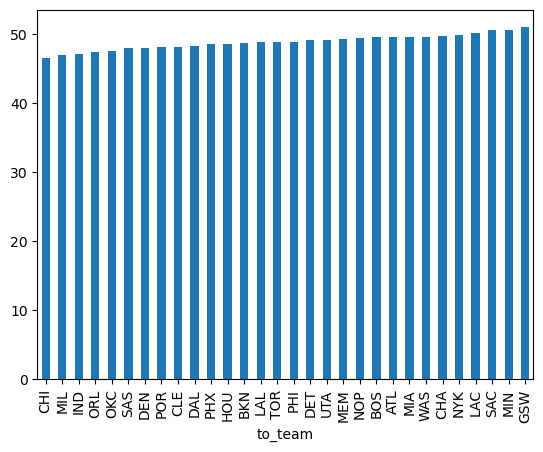

In [39]:
df_2023.groupby('to_team')['positive_prob'].mean().sort_values().plot(kind='bar')

In [76]:
coaches_df = pd.read_csv(r'C:\Users\isaac\Desktop\Proyectos\nba_analysis\timeout_analysis\preprocessing\data\regular_season_coaches.csv')

In [93]:
df_coaches = df_analysis[(df_analysis['to_non_run']==1)]

In [94]:
NBA_TEAMS = ['DEN', 'LAC', 'CHA', 'ORL', 'IND', 'NOP', 'UTA', 'TOR', 'MIA','SAC', 'POR', 'BKN', 'GSW', 'LAL', 'PHI', 'MIL', 'CHI', 'HOU','MEM', 'DET', 'DAL', 'CLE', 'MIN', 'OKC', 'PHX', 'NYK',
     'SAS', 'WAS', 'ATL','BOS']
df_coaches['to_team'] = df_coaches['to_team'].str.lstrip()
df_coaches['to_team'] = df_coaches['to_team'].str.rstrip()
df_coaches = df_coaches[df_coaches['to_team'].isin(NBA_TEAMS)]

C:\Users\isaac\AppData\Local\Temp\ipykernel_3968\4209579365.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coaches['to_team'] = df_coaches['to_team'].str.lstrip()
C:\Users\isaac\AppData\Local\Temp\ipykernel_3968\4209579365.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coaches['to_team'] = df_coaches['to_team'].str.rstrip()


In [95]:
df_coaches['Season'] = df_coaches['gp'].str[3:5].astype(int)

In [96]:
coaches_df['Season'] = coaches_df['SEASON_YEAR'] - 2000

In [97]:
coaches_df['GAME_ID'] = coaches_df['GAME_ID'].astype(str).str.zfill(10)

In [98]:
df_coaches['GAME_ID'] = df_coaches['gp'].str[:-1]

In [99]:
coaches_df['GAME_ID'] = coaches_df['GAME_ID'].astype(str)

In [113]:
df_coaches = df_coaches.merge(coaches_df[['Season','GAME_ID','TEAM_ABBREVIATION','Coach']],
                 left_on=['Season','GAME_ID','to_team'],
                 right_on=['Season','GAME_ID','TEAM_ABBREVIATION'])

In [121]:
X_all = df_coaches[model_cols].drop(['Season','next_3_avg_scoring_ratio'],axis=1)

In [122]:
X_all.fillna(0,inplace=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
pca = PCA(n_components=3)
pca_components = pca.fit_transform(X_scaled)

In [126]:
pca_components_df = pd.DataFrame(pca_components,columns=['PC1','PC2','PC3'])
pca_components_df['home_to'] = df_coaches['home_to'].values

In [127]:
cdes, y_grid_flexcode = model.predict(pca_components_df,n_grid=1000)

In [128]:
positive_probs = []
for i in range(cdes.shape[0]):
    cde = cdes[i]
    cde_df = pd.DataFrame([cde, y_grid_flexcode]).T
    cde_df.columns = ['cde', 'y_grid_flexcode']
    positive_prob = np.round((cde_df[(cde_df['cde']>0)&(cde_df['y_grid_flexcode']>0)]['cde'].sum()/cde_df['cde'].sum())*100, 2)
    positive_probs.append(positive_prob)

In [129]:
df_coaches['positive_prob'] = positive_probs

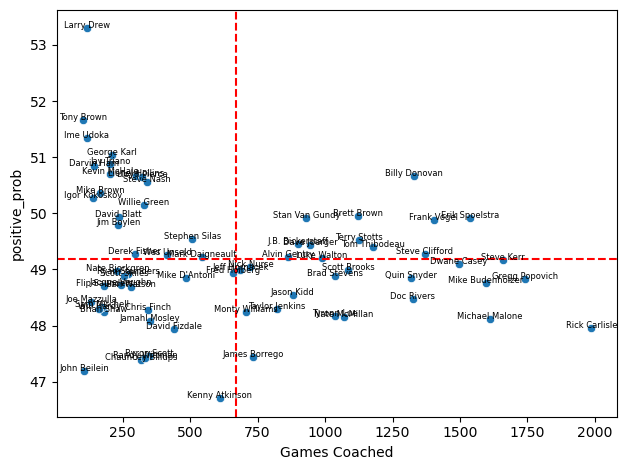

: 

In [158]:

# Group by Coach and calculate the mean positive_prob and the size
grouped = df_coaches.groupby('Coach').agg({'positive_prob': 'mean', 'Coach': 'size'}).rename(columns={'Coach': 'Games Coached'}).reset_index()
grouped = grouped[grouped['Games Coached']>=100]
# Create the scatter plot
sns.scatterplot(x='Games Coached', y='positive_prob', data=grouped)
# Add the mean lines
plt.axvline(grouped['Games Coached'].mean(), color='red', linestyle='--')
plt.axhline(grouped['positive_prob'].mean(), color='red', linestyle='--')
# Add annotations for each coach
for i, row in grouped.iterrows():
    plt.annotate(row['Coach'], (row['Games Coached'], row['positive_prob']), fontsize=6, ha='center')

plt.tight_layout()
plt.show()